Check Data Distribution: Ensure the dataset is balanced among the categories. A skewed distribution can cause the model to predict the most frequent class.
Increase Dropout: To help with overfitting, especially given your issue with converging on a single class.
Modify the Transformer Setup: Adjust parameters like the number of heads and layers, especially if your model complexity doesn't match the task complexity.
Learning Rate Scheduler: Implement a scheduler to adjust the learning rate during training, which can help in better convergence.
Model Regularization: Consider adding batch normalization layers to stabilize the learning process.
Increase Epochs: As suggested by your TA, increasing the number of training epochs might help, but first ensure that the model architecture and learning rate are optimally set.

In [1]:
from socket import gethostname
gethostname()

'hpc3-gpu-16-07'

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

Using device: cuda


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:48<00:00, 18.65it/s]


Epoch 1, Train Loss: 2.220331092966882, Val Loss: 1.5132379844249142


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:47<00:00, 19.07it/s]


Epoch 2, Train Loss: 1.4060124323499203, Val Loss: 1.3642766628467329


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:48<00:00, 18.50it/s]


Epoch 3, Train Loss: 1.273458070920932, Val Loss: 1.2220151372260122


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:44<00:00, 20.25it/s]


Epoch 4, Train Loss: 1.1782567205339054, Val Loss: 1.2507494379797166


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:45<00:00, 19.60it/s]


Epoch 5, Train Loss: 1.1035847534534264, Val Loss: 1.1437512348375136


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:46<00:00, 19.22it/s]


Epoch 6, Train Loss: 1.0392941288379356, Val Loss: 1.110306969855482


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:45<00:00, 19.59it/s]


Epoch 7, Train Loss: 0.9734130997888479, Val Loss: 1.0899678640094566


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:46<00:00, 19.16it/s]


Epoch 8, Train Loss: 0.904295277166169, Val Loss: 1.1233845884071216


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:45<00:00, 19.56it/s]


Epoch 9, Train Loss: 0.8296059992101699, Val Loss: 1.1169476142066472


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:47<00:00, 18.87it/s]


Epoch 10, Train Loss: 0.7601199887747168, Val Loss: 1.1272263885308322


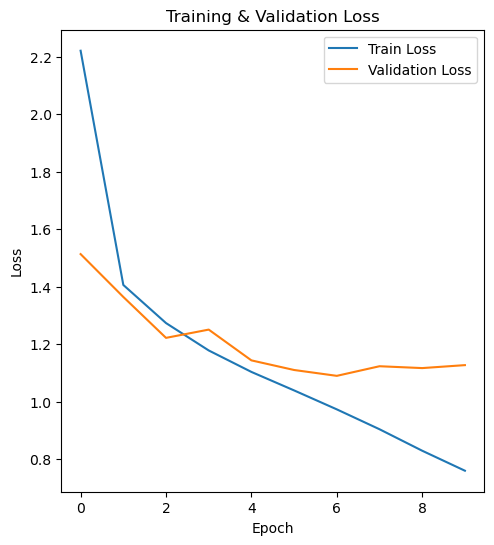

In [12]:
# Define transformations and load datasets
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the model and move it to device
class FERModel(nn.Module):
    def __init__(self):
        super(FERModel, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Increased percentage dropped to combat overfitting
            nn.Dropout(0.5)
        )
        self.to_transformer_dim = nn.Linear(256 * 12 * 12, 512)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, dropout=0.1, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=3)
        self.fc_layer = nn.Linear(256*12*12, 7)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 256*12*12)
        # x = x.view(x.size(0), -1)
        # x = self.to_transformer_dim(x)
        # x = x.unsqueeze(1)
        # x = self.transformer_encoder(x)
        # x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x

# Initialize model, optimizer, loss function, and scheduler
model = FERModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# scheduler = ExponentialLR(optimizer, gamma=0.95)

# Lists to store metrics
train_losses = []
val_losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)
    
    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * images.size(0)
    avg_val_loss = total_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)


    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

# Plotting the training and validation losses and learning rate
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_loader is your DataLoader for the test dataset
true_labels = []
predicted_labels = []
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Overall Accuracy: {overall_accuracy:.2f}')


Overall Accuracy: 0.59


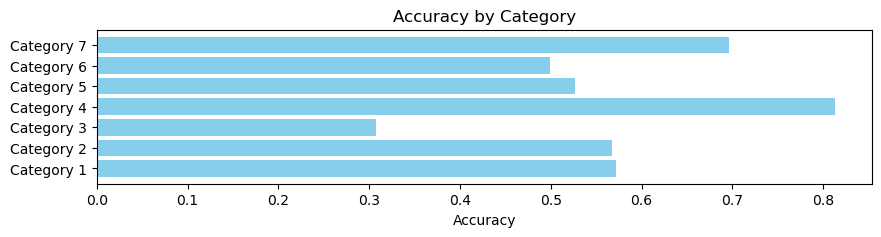

In [14]:
import numpy as np

category_accuracies = []
for i in range(7):
    category_mask = (np.array(true_labels) == i)
    category_acc = accuracy_score(np.array(true_labels)[category_mask], np.array(predicted_labels)[category_mask])
    category_accuracies.append(category_acc)

# Plotting category accuracies
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust the size as needed
ax.barh(range(7), category_accuracies, color='skyblue')
ax.set_xlabel('Accuracy')
ax.set_yticks(range(7))
ax.set_yticklabels(['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5', 'Category 6', 'Category 7'])
ax.set_title('Accuracy by Category')
plt.show()

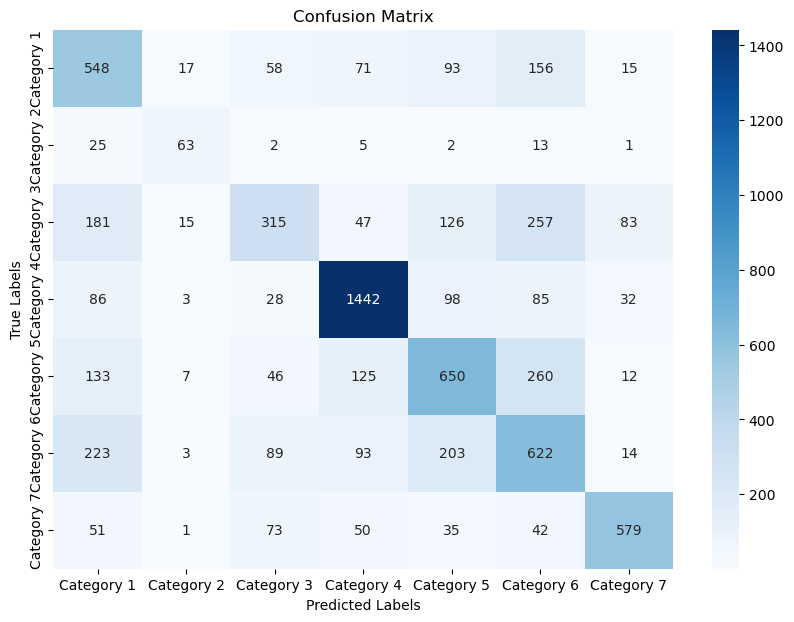

In [15]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5', 'Category 6', 'Category 7'], yticklabels=['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5', 'Category 6', 'Category 7'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
